<a href="https://colab.research.google.com/github/Tony5t4rk/ML-2021-Spring/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3 - Convolutional Neural Network**

作者: 刘阳

学习笔记：[機器學習2021 学习笔记-CNN & Self-Attention](https://www.wolai.com/tony5t4rk/jFYeVKmHKnfwJyLEK18Gbh?theme=light)

本HW01在[样例代码](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW03/HW03.ipynb#scrollTo=VHpJocsDr6iA)的基础上进行修改。


# 挂载到Google Drive

In [155]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab/ML 2021 Spring/HW03'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab/ML 2021 Spring/HW03


# 查看当前设备GPU

In [156]:
!nvidia-smi

Thu May  6 09:04:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    38W / 250W |   9327MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 从Google Drive下载数据

In [157]:
# !gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip
# !unzip -q food-11.zip
!apt-get -qq install -y tree
!tree -L 3

train_path = 'food-11/training'
val_path = 'food-11/validation'
test_path = 'food-11/testing'

.
├── CNN.ipynb
├── food-11
│   ├── testing
│   │   └── 00
│   ├── training
│   │   ├── labeled
│   │   └── unlabeled
│   └── validation
│       ├── 00
│       ├── 01
│       ├── 02
│       ├── 03
│       ├── 04
│       ├── 05
│       ├── 06
│       ├── 07
│       ├── 08
│       ├── 09
│       └── 10
├── food-11.pred.csv
├── food-11.zip
├── Learning curve of CNN Model.svg
└── models
    └── model.pth

19 directories, 5 files


# 导入需要使用的模块

In [158]:
# PyTorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# 数据处理
import numpy as np
import os
from PIL import Image
from tqdm import tqdm

# 绘图
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# 绘制矢量图片
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置随机数种子（为了实验的可复现性）
my_seed = 42096
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# 定义画图工具函数

In [159]:
# 绘制深度神经网络学习曲线（训练和验证的Loss）
def plot_learning_curve(loss_record, title=''):
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig('Learning curve of {}.svg'.format(title))
    plt.show()

# 预处理

## 数据处理

In [160]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

## 数据迭代器

In [161]:
def set_dataloader(batch_size):
    train_dataset = DatasetFolder(os.path.join(train_path, 'labeled'), loader=lambda x: Image.open(x), extensions='jpg', transform=train_transform)
    val_dataset = DatasetFolder(val_path, loader=lambda x: Image.open(x), extensions='jpg', transform=test_transform)
    test_dataset = DatasetFolder(test_path, loader=lambda x: Image.open(x), extensions='jpg', transform=test_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader

# 定义Model

In [162]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x
    
    def calc_loss(self, pred, target):
        return self.criterion(pred, target)

# 训练 & 验证 & 测试

## 训练

In [163]:
def train(train_dataloader, val_dataloader, model, config, device):
    n_epochs = config['n_epochs']
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparams'])
    min_val_loss = float('inf')
    loss_record = {'train': [], 'val': []}
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = model.calc_loss(logits, y)
            loss.backward()
            optimizer.step()
            loss_record['train'].append(loss.detach().cpu().item())

        val_loss = val(val_dataloader, model, device)
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {val_loss:.5f}")
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            # print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_val_loss))
            torch.save(model, config['model_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
        
        epoch += 1
        loss_record['val'].append(val_loss)
        if early_stop_cnt > config['early_stop']:
            break
    print('Finish train after {} epochs'.format(epoch))
    return min_val_loss, loss_record

## 验证

In [164]:
def val(val_dataloader, model, device):
    model.eval()
    total_loss = 0
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            loss = model.calc_loss(logits, y)
        total_loss += loss.detach().cpu().item() * len(x)
    total_loss /= len(val_dataloader.dataset)
    return total_loss

## 测试

In [165]:
def test(test_dataloader, model, config, device):
    model.eval()
    preds = []
    for x, _ in test_dataloader:
        x, _ = x.to(device), _.to(device)
        with torch.no_grad():
            logits = model(x)
        preds.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    return preds

# 配置Hyper-parameters

In [166]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')
os.makedirs('models', exist_ok=True)

config = {
    'n_epochs': 80,
    'batch_size': 128,
    'optimizer': 'Adam',
    'optim_hparams': {
        'lr': 0.0003,
        'weight_decay': 1e-5
    },
    'early_stop': 80,
    'model_path': 'models/model.pth'
}

device: cuda


# 加载数据

In [167]:
train_dataloader, val_dataloader, test_dataloader = set_dataloader(config['batch_size'])

# 加载Model

In [168]:
model = Net().to(device)

# 开始训练

In [169]:
model_min_dev_loss, model_loss_record = train(train_dataloader, val_dataloader, model, config, device)

[ Valid | 001/080 ] loss = 2.39993
[ Valid | 002/080 ] loss = 2.06664
[ Valid | 003/080 ] loss = 1.83237
[ Valid | 004/080 ] loss = 1.82954
[ Valid | 005/080 ] loss = 1.76240
[ Valid | 006/080 ] loss = 1.97554
[ Valid | 007/080 ] loss = 1.66652
[ Valid | 008/080 ] loss = 1.82234
[ Valid | 009/080 ] loss = 1.81673
[ Valid | 010/080 ] loss = 1.70488
[ Valid | 011/080 ] loss = 1.61024
[ Valid | 012/080 ] loss = 1.64698
[ Valid | 013/080 ] loss = 1.77431
[ Valid | 014/080 ] loss = 1.70644
[ Valid | 015/080 ] loss = 1.91795
[ Valid | 016/080 ] loss = 1.77251
[ Valid | 017/080 ] loss = 1.64172
[ Valid | 018/080 ] loss = 1.92467
[ Valid | 019/080 ] loss = 1.90574
[ Valid | 020/080 ] loss = 1.80443
[ Valid | 021/080 ] loss = 2.00959
[ Valid | 022/080 ] loss = 1.77485
[ Valid | 023/080 ] loss = 2.30251
[ Valid | 024/080 ] loss = 1.87328
[ Valid | 025/080 ] loss = 2.29268
[ Valid | 026/080 ] loss = 1.97312
[ Valid | 027/080 ] loss = 2.25702
[ Valid | 028/080 ] loss = 1.92322
[ Valid | 029/080 ] 

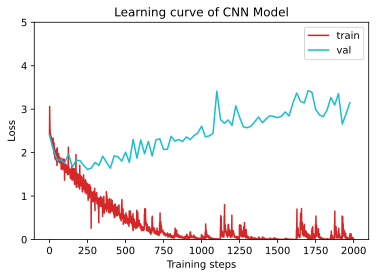

In [170]:
plot_learning_curve(model_loss_record, title='CNN Model')

In [171]:
# del model
# model = torch.load(config['model_path']).to(device)

# 测试

In [172]:
def save_pred(preds, file):
    print('Saving result to {}'.format(file))
    with open(file, 'w') as fp:
        fp.write('Id,Category\n')
        for id, pred in enumerate(preds):
            fp.write('{},{}\n'.format(id, pred))

preds = test(test_dataloader, model, config, device)
save_pred(preds, 'food-11.pred.csv')

Saving result to food-11.pred.csv


# 结果